In [1]:
#!pip install -q segmentation-models-pytorch==0.3.5 torchinfo
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
#import segmentation_models_pytorch as smp
from PIL import Image
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

# tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='models/runs/segmentation')


/home/gonzagrau/miniconda3/envs/redes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-20 14:52:00.435879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 14:52:00.451261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_DIR   = "/home/gonzagrau/Documents/ITBA/PFC/iamedic-demo"
IMG_DIR    = os.path.join(DATA_DIR ,'preprocessed_images')
MASK_DIR   = os.path.join(DATA_DIR ,'segmentations')

In [3]:

# 2) Gather and filter filenames
all_imgs = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
valid_imgs = [
    img for img in all_imgs
    if os.path.exists(os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png"))
]

#print(f"Found {len(valid_imgs)} image–mask pairs.")

# 3) Split into train / test (80/20)
train_files, test_files = train_test_split(
    valid_imgs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

#print(f"Train on {len(train_files)} images, test on {len(test_files)} images.")

# 4) Build full paths lists
train_imgs  = [os.path.join(IMG_DIR,  img) for img in train_files]
train_masks = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in train_files]

test_imgs   = [os.path.join(IMG_DIR,  img) for img in test_files]
test_masks  = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in test_files]



In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

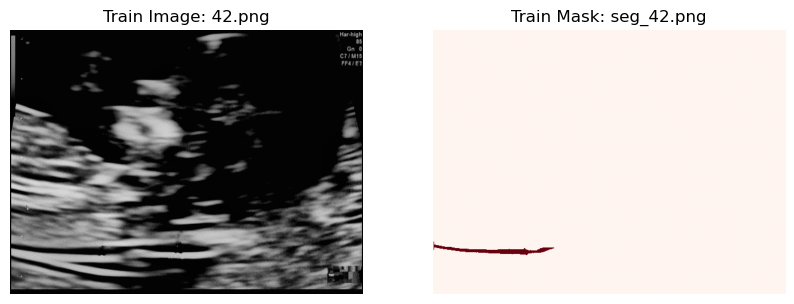

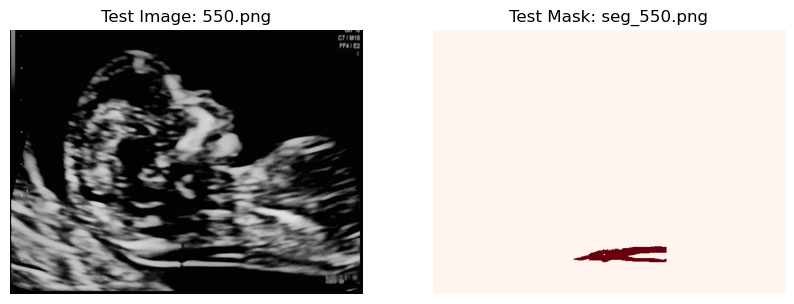

In [5]:
# Convert to lists if they’re Paths
train_files = [f.name if hasattr(f, 'name') else f for f in train_files]
test_files  = [f.name if hasattr(f, 'name') else f for f in test_files]

# Choose random samples
train_sample = random.choice(train_files)
test_sample  = random.choice(test_files)

# Paths
train_img  = os.path.join(IMG_DIR, train_sample)
train_mask = os.path.join(MASK_DIR, f"seg_{os.path.splitext(train_sample)[0]}.png")
test_img   = os.path.join(IMG_DIR, test_sample)
test_mask  = os.path.join(MASK_DIR,  f"seg_{os.path.splitext(test_sample)[0]}.png")

def plot_pair(img_path, mask_path, title):
    img  = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)
    if mask.max() <= 1.0:
        mask = mask * 255

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"{title} Image: {os.path.basename(img_path)}")
    ax1.axis('off')

    ax2.imshow(mask, cmap='Reds')
    ax2.set_title(f"{title} Mask: {os.path.basename(mask_path)}")
    ax2.axis('off')
    plt.show()

# Display
plot_pair(train_img, train_mask, 'Train')
plot_pair(test_img, test_mask,   'Test')

In [6]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Number of train masks:  {len(train_masks)}")

print(f"Number of test images:  {len(test_imgs)}")
print(f"Number of test masks:   {len(test_masks)}")

Number of train images: 888
Number of train masks:  888
Number of test images:  222
Number of test masks:   222


In [7]:
from collections import Counter
import cv2

In [8]:

def get_shapes(paths):
    shapes = [cv2.imread(p, cv2.IMREAD_UNCHANGED).shape[:2] for p in paths]
    # shape[:2] is (height, width)
    return Counter(shapes)

# your four lists:
#   train_imgs, train_masks, test_imgs, test_masks

print(f"Number of train images: {len(train_imgs)}")
print(f"Train image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of train masks: {len(train_masks)}")
print(f"Train mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_masks).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test images: {len(test_imgs)}")
print(f"Test image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test masks: {len(test_masks)}")
print(f"Test mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_masks).items():
    print(f"  {h}×{w}: {cnt}")

Number of train images: 888
Train image dimensions (H×W) frequency:
  450×600: 888

Number of train masks: 888
Train mask dimensions (H×W) frequency:
  450×600: 888

Number of test images: 222
Test image dimensions (H×W) frequency:
  450×600: 222

Number of test masks: 222
Test mask dimensions (H×W) frequency:
  450×600: 222


In [9]:

class FetusSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        assert len(image_paths) == len(mask_paths), "Images and masks counts must match"
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms  = transforms or T.Compose([
            T.Resize((256,256)),      # optional: down/up-sample
            T.ToTensor(),             # [0–255] → [0–1], shape [C,H,W]
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load grayscale image & mask
        img  = Image.open(self.image_paths[idx]).convert('L')
        msk  = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply identical transforms
        img_t = self.transforms(img)
        msk_t = self.transforms(msk)
        
        # Optionally: binarize mask (if not already 0/1)
        msk_t = (msk_t > 0.5).float()
        
        return img_t, msk_t

# --- Transforms (you can add normalization or augmentation here) ---
TARGET_SIZE = (400, 600)  # target size for images and masks
transforms = T.Compose([
    T.Resize(TARGET_SIZE),   # keep original size
    T.ToTensor(),          # → [0,1]
])

# 1) Create datasets
train_ds = FetusSegDataset(train_imgs,  train_masks, transforms=transforms)
test_ds  = FetusSegDataset(test_imgs,   test_masks,  transforms=transforms)

# 2) Create loaders
batch_size = 4
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Quick sanity‐check
# Pull one batch and inspect shapes
imgs, masks = next(iter(train_loader))
print("Images batch:", imgs.shape)   # e.g. [8, 1, 450, 600]
print("Masks batch: ", masks.shape)  # e.g. [8, 1, 450, 600]

Images batch: torch.Size([4, 1, 400, 600])
Masks batch:  torch.Size([4, 1, 400, 600])


In [10]:
#check the max and mean values of an image in the bach as well as the masks 
print("Max value in images batch:", imgs.max().item())  # should be ~1.0
print("Min value in images batch:", imgs.min().item())  # should be ~0.5
print("Max value in masks batch:", masks.max().item())  # should be 1.0
print("Min value in masks batch:", masks.min().item())  # should be ~0.5
# Check if the images and masks are correctly paired

Max value in images batch: 0.8705882430076599
Min value in images batch: 0.007843137718737125
Max value in masks batch: 1.0
Min value in masks batch: 0.0


In [11]:
# 1) Set a batch size
batch_size = 8

# 2) Create the loaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,      # shuffle for training
    num_workers=2,     # adjust to your machine
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,     # no shuffle for validation
    num_workers=2,
    pin_memory=True
)

# 3) Sanity check
imgs, masks = next(iter(train_loader))
print("Train batch  images:", imgs.shape)   # [batch, 1, H, W]
print("Train batch  masks: ", masks.shape)  # [batch, 1, H, W]

Train batch  images: torch.Size([8, 1, 400, 600])
Train batch  masks:  torch.Size([8, 1, 400, 600])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:


# 1) Building blocks

class DoubleConv(nn.Module):
    """(conv ⇒ ReLU ⇒ conv ⇒ ReLU)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        # choose upsampling method
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            mid_ch = in_ch // 2
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            mid_ch = in_ch // 2

        self.conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        # x1 is decoder input, x2 is encoder skip connection
        x1 = self.up(x1)
        # input is CHW, adjust pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        # concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """1×1 conv to map to output channels"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# 2) UNet assembly

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, bilinear=True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.bilinear     = bilinear

        # encoder (contracting path)
        self.inc    = DoubleConv(in_channels, 64)
        self.down1  = Down(64, 128)
        self.down2  = Down(128, 256)
        self.down3  = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4  = Down(512, 1024 // factor)

        # decoder (expansive path)
        self.up1    = Up(1024, 512 // factor, bilinear)
        self.up2    = Up(512, 256 // factor, bilinear)
        self.up3    = Up(256, 128 // factor, bilinear)
        self.up4    = Up(128, 64, bilinear)

        # final 1x1 convolution
        self.outc   = OutConv(64, out_channels)

    def forward(self, x):
        # encoding
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 1024

        # decoding with skip connections
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)

        logits = self.outc(x)
        return logits

In [15]:
model  = UNet(in_channels=1, out_channels=1, bilinear=True).to(device)

In [16]:
# x = torch.randn(1, 1, 450, 600, device=device)
# with torch.no_grad():
#     out = model(x)
# print("Input shape :", x.shape)
# print("Output shape:", out.shape)  # should be [1,1,450,600]

In [17]:
import torch.optim as optim
from segmentation_models_pytorch.utils.metrics import IoU

In [18]:
# Binary segmentation: logits → mask
loss_fn   = nn.BCEWithLogitsLoss()          # combines Sigmoid + BCELoss
metric_fn = IoU(threshold=0.5)              # or write your own Dice/IoU

optimizer = optim.Adam(model.parameters(), lr=1e-4)
# (Optional) a LR scheduler, e.g. ReduceLROnPlateau on val loss:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [19]:
from tqdm.auto import tqdm

num_epochs = 30
best_val_iou = 0.0

# Main training loop
for epoch in range(1, num_epochs+1):
    # ——— Training ———
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch:02d}')
    for imgs, masks in train_pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        # Update progress bar description
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    epoch_train_loss = running_loss / len(train_loader.dataset)
    
    # Log training metrics
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)

    # ——— Validation ———
    model.eval()
    val_loss, val_iou = 0.0, 0.0
    val_pbar = tqdm(test_loader, desc=f'Validation Epoch {epoch:02d}')
    with torch.no_grad():
        for imgs, masks in val_pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            logits       = model(imgs)
            loss         = loss_fn(logits, masks)
            val_loss    += loss.item() * imgs.size(0)
            # apply sigmoid then metric
            preds       = torch.sigmoid(logits)
            val_iou    += metric_fn(preds, masks).item() * imgs.size(0)
            # Update progress bar description
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    epoch_val_loss = val_loss / len(test_loader.dataset)
    epoch_val_iou  = val_iou  / len(test_loader.dataset)

    # Log validation metrics
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('IoU/val', epoch_val_iou, epoch)

    # ——— Logging & Scheduler ———
    print(f"\nEpoch {epoch:02d} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val IoU: {epoch_val_iou:.4f}")
    scheduler.step(epoch_val_loss)

    # ——— Checkpointing ———
    if epoch_val_iou > best_val_iou:
        best_val_iou = epoch_val_iou
        torch.save(model.state_dict(), "best_unet.pth")
        print("  Saved new best model.")

# Close tensorboard writer
writer.close()

Validation Epoch 01: 100%|██████████| 28/28 [00:07<00:00,  3.79it/s, loss=0.3069]



Epoch 01 | Train Loss: 0.3743 | Val Loss: 0.3056 | Val IoU: 0.0005
  Saved new best model.


Validation Epoch 02: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s, loss=0.2567]



Epoch 02 | Train Loss: 0.2778 | Val Loss: 0.2551 | Val IoU: 0.4666
  Saved new best model.


Validation Epoch 03: 100%|██████████| 28/28 [00:07<00:00,  3.77it/s, loss=0.2095]



Epoch 03 | Train Loss: 0.2301 | Val Loss: 0.2087 | Val IoU: 0.6087
  Saved new best model.


Validation Epoch 04: 100%|██████████| 28/28 [00:07<00:00,  3.78it/s, loss=0.1806]



Epoch 04 | Train Loss: 0.1978 | Val Loss: 0.1810 | Val IoU: 0.6001


Validation Epoch 05: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s, loss=0.1532]



Epoch 05 | Train Loss: 0.1647 | Val Loss: 0.1530 | Val IoU: 0.6113
  Saved new best model.


Validation Epoch 06: 100%|██████████| 28/28 [00:06<00:00,  4.05it/s, loss=0.1282]



Epoch 06 | Train Loss: 0.1405 | Val Loss: 0.1292 | Val IoU: 0.6555
  Saved new best model.


Validation Epoch 07: 100%|██████████| 28/28 [00:06<00:00,  4.07it/s, loss=0.1129]



Epoch 07 | Train Loss: 0.1208 | Val Loss: 0.1124 | Val IoU: 0.6055


Validation Epoch 08: 100%|██████████| 28/28 [00:06<00:00,  4.09it/s, loss=0.0971]



Epoch 08 | Train Loss: 0.1045 | Val Loss: 0.0968 | Val IoU: 0.6586
  Saved new best model.


Validation Epoch 09: 100%|██████████| 28/28 [00:06<00:00,  4.07it/s, loss=0.0835]



Epoch 09 | Train Loss: 0.0904 | Val Loss: 0.0837 | Val IoU: 0.6704
  Saved new best model.


Validation Epoch 10: 100%|██████████| 28/28 [00:07<00:00,  3.84it/s, loss=0.0760]



Epoch 10 | Train Loss: 0.0804 | Val Loss: 0.0783 | Val IoU: 0.6262


Validation Epoch 11: 100%|██████████| 28/28 [00:07<00:00,  3.93it/s, loss=0.0650]



Epoch 11 | Train Loss: 0.0696 | Val Loss: 0.0640 | Val IoU: 0.6621


Validation Epoch 12: 100%|██████████| 28/28 [00:06<00:00,  4.03it/s, loss=0.0557]



Epoch 12 | Train Loss: 0.0602 | Val Loss: 0.0573 | Val IoU: 0.6790
  Saved new best model.


Validation Epoch 13: 100%|██████████| 28/28 [00:06<00:00,  4.06it/s, loss=0.0468]



Epoch 13 | Train Loss: 0.0534 | Val Loss: 0.0468 | Val IoU: 0.6678


Validation Epoch 14: 100%|██████████| 28/28 [00:07<00:00,  3.96it/s, loss=0.0438]



Epoch 14 | Train Loss: 0.0473 | Val Loss: 0.0454 | Val IoU: 0.6523


Validation Epoch 15: 100%|██████████| 28/28 [00:06<00:00,  4.09it/s, loss=0.0372]



Epoch 15 | Train Loss: 0.0422 | Val Loss: 0.0393 | Val IoU: 0.6918
  Saved new best model.


Validation Epoch 16: 100%|██████████| 28/28 [00:06<00:00,  4.10it/s, loss=0.0388]



Epoch 16 | Train Loss: 0.0378 | Val Loss: 0.0396 | Val IoU: 0.6344


Validation Epoch 17: 100%|██████████| 28/28 [00:06<00:00,  4.08it/s, loss=0.0334]



Epoch 17 | Train Loss: 0.0342 | Val Loss: 0.0352 | Val IoU: 0.6762


Validation Epoch 18: 100%|██████████| 28/28 [00:06<00:00,  4.00it/s, loss=0.0313]



Epoch 18 | Train Loss: 0.0308 | Val Loss: 0.0303 | Val IoU: 0.6916


Training Epoch 19:  14%|█▍        | 16/111 [00:14<01:24,  1.12it/s, loss=0.0263]


KeyboardInterrupt: 

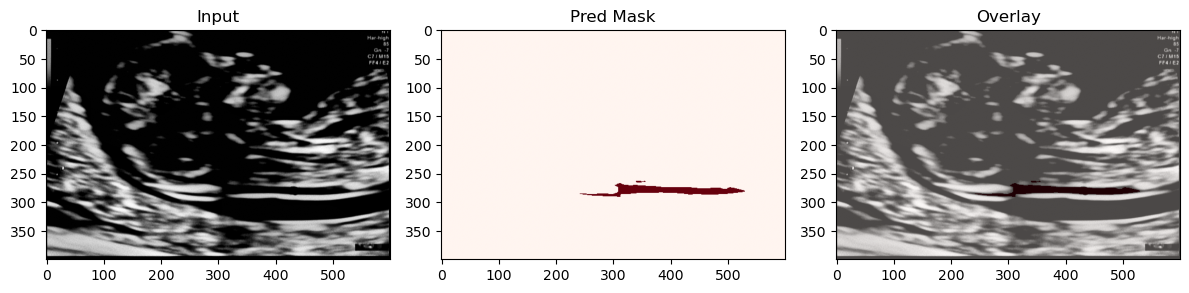

In [20]:
# load best weights
model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

# single-image inference example
img, _ = next(iter(test_loader))  # take one batch
img = img.to(device)
with torch.no_grad():
    logits = model(img)
    probs  = torch.sigmoid(logits)  # [B,1,H,W]
    preds  = (probs > 0.5).float()

# visualize first sample
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(preds[0,0].cpu(), cmap='Reds'); plt.title("Pred Mask")
plt.subplot(1,3,3); plt.imshow(img[0,0].cpu(), cmap='gray'); 
plt.imshow(preds[0,0].cpu(), cmap='Reds', alpha=0.3); plt.title("Overlay")
plt.tight_layout(); plt.show()


Model exported to unet_fetus_segmentation.onnx
ONNX model is valid.


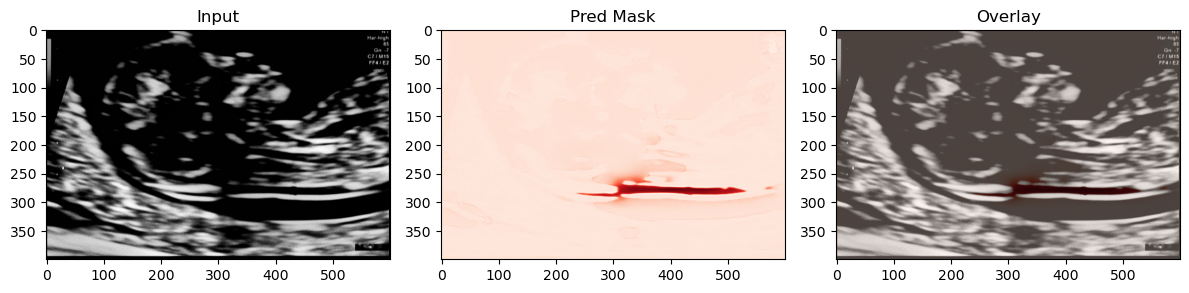

In [22]:
# Save model as onnx
import torch.onnx
onnx_path = "unet_fetus_segmentation.onnx"
torch.onnx.export(
    model,
    img,  # dummy input
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},  # variable batch size
        'output': {0: 'batch_size'}
    }
)
print(f"Model exported to {onnx_path}")
# Load ONNX model and check
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")
# Visualize outputs like before
import onnxruntime as ort
ort_session = ort.InferenceSession(onnx_path)
# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: img.cpu().numpy()}
ort_outputs = ort_session.run(None, ort_inputs)
# Convert outputs to tensors
ort_preds = torch.tensor(ort_outputs[0])
# Visualize first sample
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img[0,0].cpu(), cmap='gray'); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(ort_preds[0,0].cpu(), cmap='Reds'); plt.title("Pred Mask")
plt.subplot(1,3,3); plt.imshow(img[0,0].cpu(), cmap='gray');
plt.imshow(ort_preds[0,0].cpu(), cmap='Reds', alpha=0.3); plt.title("Overlay")
plt.tight_layout(); plt.show()